<a href="https://colab.research.google.com/github/tonyjosephsebastians/100DaysMLCode/blob/main/prototype_211112_multi_class_11_labels_success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import packages

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import shutil

# random seeds must be set before importing keras & tensorflow
my_seed = 512
np.random.seed(my_seed)

import random 
random.seed(my_seed)

import tensorflow as tf
# tf.set_random_seed(my_seed)

import seaborn as sns
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping
from tensorflow import keras


# 2. Load images and tags from datasource


In [ ]:
df = pd.DataFrame([], columns=['FileName', 'Label'])

# folderPath = 'clusters_level1'
folderPath = '/content/drive/MyDrive/Colab Notebooks/dataset/clusters_level1_211111'

for dirPath, subdirList, fileList in tqdm(sorted(list(os.walk(folderPath)), reverse=True)):
    # We ignore the root folder
    if dirPath == folderPath:
        continue

    # We split the folder path to parts
    sep = dirPath.split(os.sep)

    for file in fileList:

        if '.DS_Store' in file:
            continue

        # print(sep)
        df = df.append([{"FileName": file, 'Label': os.path.join(*sep[-1:])}])


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


In [ ]:
df.describe()

,FileName,Label
count,7699,7699
unique,7688,19
top,111699__hoozing-1eb9bc04-c1d5-40c3-894f-ee1298...,Bathroom
freq,2,1869


# 3. Data Wrangling

## 3.1 Check the number of images in each label

In [ ]:
all_labels = dict(df[['Label']].value_counts())

all_labels

{('Air Coordinator',): 3,
 ('Bacony',): 162,
 ('Bathroom',): 1869,
 ('Bedroom',): 1255,
 ('Closet',): 4,
 ('Dish Washer',): 5,
 ('Document',): 13,
 ('Empty Room',): 206,
 ('Kitchen',): 846,
 ('Living Room',): 1333,
 ('Microwave',): 2,
 ('Outlook',): 1108,
 ('Outlook - Night',): 61,
 ('Refrigerator',): 72,
 ('Shelf',): 66,
 ('TV',): 14,
 ('Table',): 498,
 ('Washing Machine',): 161,
 ('Windows View',): 21}

(<Figure size 1080x720 with 1 Axes>,
 Text(0.5, 1.0, 'Number of samples in each label'))

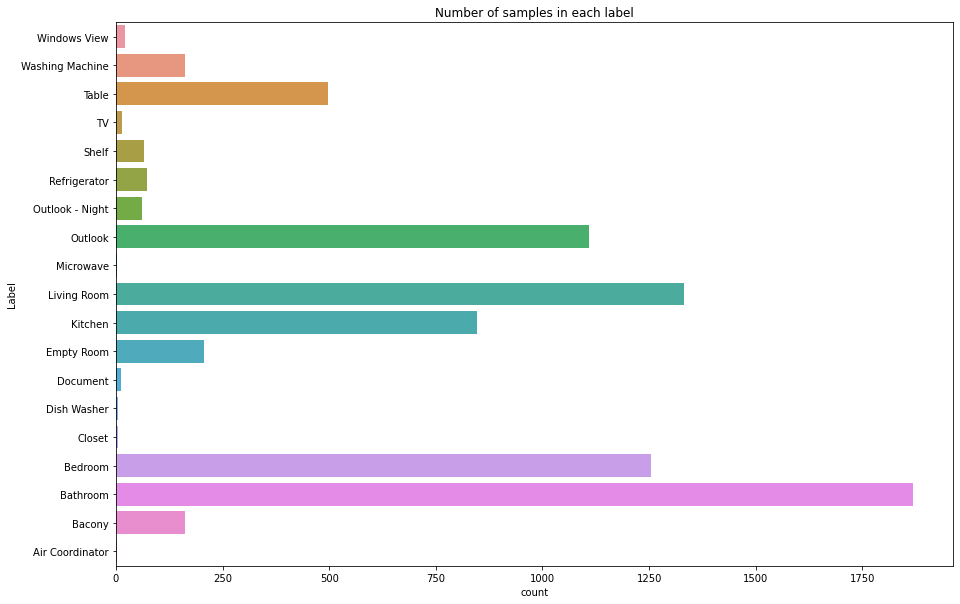

In [ ]:
plt.figure(figsize=(15, 10)), sns.countplot(data = df, y = 'Label'), plt.title('Number of samples in each label')

## 3.2 Remove too small subset labels

In [ ]:

# Store small subset labels here so that we can remove all records of them out of the dataset
# Too small subsets lead to failture in building a accuracy model
small_subset_labels = []
for key, value in all_labels.items():
  if value <= 60 or key[0] in ['Shelf', 'Refrigerator']:
    # print(key, value)
    small_subset_labels.append(key[0])

# print('small_subset_labels:', small_subset_labels)

small_subset_labels


['Refrigerator',
 'Shelf',
 'Windows View',
 'TV',
 'Document',
 'Dish Washer',
 'Closet',
 'Air Coordinator',
 'Microwave']

## 3.3 Remove all records belong to small_subset_labels

In [ ]:
df = df[df['Label'].isin(small_subset_labels) == False]
print(df.shape)

(7499, 2)


## 3.4 Check the labels again to make sure everything is correct

In [ ]:
all_labels = dict(df[['Label']].value_counts())

all_labels

{('Bacony',): 162,
 ('Bathroom',): 1869,
 ('Bedroom',): 1255,
 ('Empty Room',): 206,
 ('Kitchen',): 846,
 ('Living Room',): 1333,
 ('Outlook',): 1108,
 ('Outlook - Night',): 61,
 ('Table',): 498,
 ('Washing Machine',): 161}

## 3.5 Make sure each labels has the same number of samples

In [ ]:
df2 = pd.DataFrame([], columns = df.columns)

for label in all_labels:
  print(label[0])
  df2 = df2.append(df[df['Label'] == label[0]].head(170), ignore_index=True)

df = df2
# df.groupby('Label').count()

Bathroom
Living Room
Bedroom
Outlook
Kitchen
Table
Empty Room
Bacony
Washing Machine
Outlook - Night


(<Figure size 1080x720 with 1 Axes>,
 Text(0.5, 1.0, 'Number of samples in each label'))

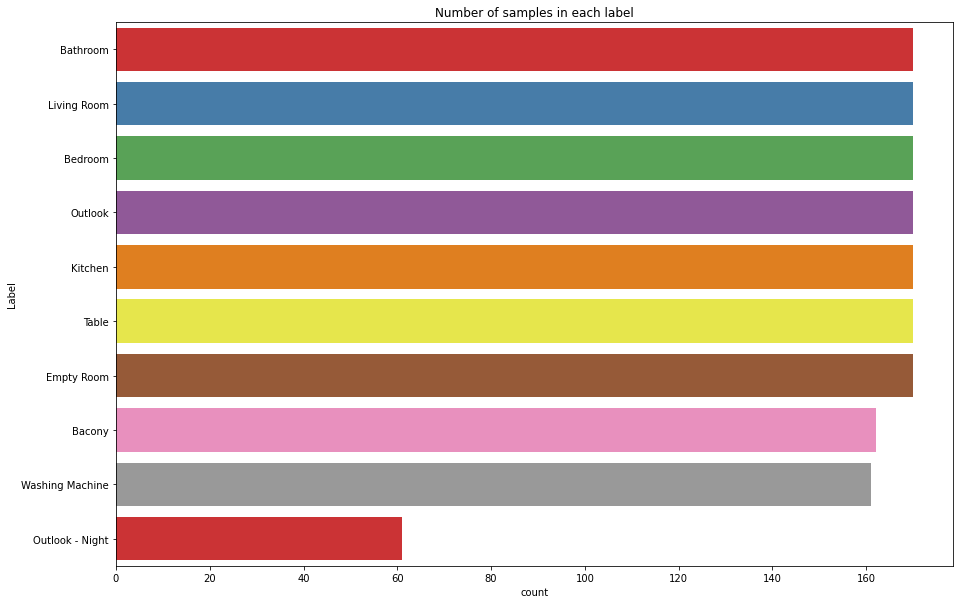

In [ ]:
plt.figure(figsize=(15, 10)), sns.countplot(data = df, y = 'Label', palette='Set1'), plt.title('Number of samples in each label')

## 3.6 High model accuracy vs very low validation accuarcy
https://datascience.stackexchange.com/questions/29893/high-model-accuracy-vs-very-low-validation-accuarcy

In [ ]:
# shuffle the DataFrame rows
df = df.sample(frac = 1)

df

,FileName,Label
605,112391__hoozing-d4668942-62a2-432e-b4f1-99256d...,Outlook
611,112426__hoozing-57e7dc3d-35b8-47a5-9060-a5e42f...,Outlook
657,114419__hoozing-cd00eceb-67ef-4a5d-b064-05ab49...,Outlook
1285,171066__hoozing-15e742cb-b3bc-459a-a422-f7a4a9...,Bacony
945,124657__hoozing_0_112054_done-09341.jpg,Table
...,...,...
1261,150197__2019 4:51:19 PM_DONE-9.jpg,Bacony
643,112690__hoozing-96df775e-d500-4dd5-8ed2-cb8e5d...,Outlook
360,140269__636801289785437624_Done-8.jpg,Bedroom
929,118479__hoozing-0d78514c-ca08-409a-993d-d9a087...,Table


# 4. Preprocessing


## 4.1 Encode labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

encoder.fit(df['Label'])

df['Encoded'] = encoder.transform(df['Label'])

print(len(encoder.classes_))

10


In [ ]:
df

,FileName,Label,Encoded
605,112391__hoozing-d4668942-62a2-432e-b4f1-99256d...,Outlook,6
611,112426__hoozing-57e7dc3d-35b8-47a5-9060-a5e42f...,Outlook,6
657,114419__hoozing-cd00eceb-67ef-4a5d-b064-05ab49...,Outlook,6
1285,171066__hoozing-15e742cb-b3bc-459a-a422-f7a4a9...,Bacony,0
945,124657__hoozing_0_112054_done-09341.jpg,Table,8
...,...,...,...
1261,150197__2019 4:51:19 PM_DONE-9.jpg,Bacony,0
643,112690__hoozing-96df775e-d500-4dd5-8ed2-cb8e5d...,Outlook,6
360,140269__636801289785437624_Done-8.jpg,Bedroom,2
929,118479__hoozing-0d78514c-ca08-409a-993d-d9a087...,Table,8


## 4.2 Read images file 

In [ ]:
import numpy as np

from keras.preprocessing import image
from keras.layers import Dense, Reshape, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input

IMG_HEIGHT = 400
IMG_WIDTH = 400

images = []

# folderPath = './clusters_level1/' 
folderPath = '/content/drive/MyDrive/Colab Notebooks/dataset/clusters_level1_211111/'

for index, row in df.iterrows():
    image_id = row['FileName']
    label = row['Label']
    
    image_path = folderPath + label + '/' + image_id

    if image_id.endswith('textClipping'):
      continue

    # print(image_path)

    img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    img_array = image.img_to_array(img)
    # img_array = np.expand_dims(img_array, axis=0)

    # img_array = img_array/255
    img_array = preprocess_input(img_array)

    images.append(img_array)

images = np.array(images)
# images

print(images.shape, type(images))

y = df[['Encoded']].to_numpy()

print(images.shape, type(y))
print(y.shape, type(y))

(1574, 400, 400, 3) <class 'numpy.ndarray'>
(1574, 400, 400, 3) <class 'numpy.ndarray'>
(1574, 1) <class 'numpy.ndarray'>


# 5. Save dataset

In [ ]:
# import pickle

# with open('/content/drive/MyDrive/Colab Notebooks/dataset/first-prototype-211106/images.pkl', 'wb') as file:
#     pickle.dump(images, file)

# with open('/content/drive/MyDrive/Colab Notebooks/dataset/first-prototype-211106/y.pkl', 'wb') as file:
#     pickle.dump(y, file)

# 6. Load dataset

In [ ]:
# import pickle
 
# with open('/content/drive/MyDrive/Colab Notebooks/dataset/first-prototype-211022/images.pkl', 'rb') as file:
#     images = pickle.load(file)

# with open('/content/drive/MyDrive/Colab Notebooks/dataset/first-prototype-211022/y.pkl', 'rb') as file:
#     y = pickle.load(file)

# images.shape

# 6. Split to train and test datasets

In [ ]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(images, y[:,:20], test_size=0.0, random_state=1)
X_train = images
y_train = y[:,:20]

# y_train.shape

# 7. Build model using a pre-trained model

In [ ]:
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1000, activation='relu')(flat1)
output = Dense(len(encoder.classes_), activation='softmax')(class1)

# define new model
model = Model(inputs=model.inputs, outputs=output)


# mark loaded layers as not trainable
for layer in model.layers[:-3]:
	layer.trainable = False

# summarize
# model.summary()

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

es_callback = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=16, callbacks=es_callback)
# model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/100
79/79 [==============================] - 12s 142ms/step - loss: 249.3115 - accuracy: 0.7387 - val_loss: 21.0927 - val_accuracy: 0.8032
Epoch 2/100
79/79 [==============================] - 10s 130ms/step - loss: 38.6525 - accuracy: 0.9047 - val_loss: 32.1896 - val_accuracy: 0.8698
Epoch 3/100
79/79 [==============================] - 10s 130ms/step - loss: 20.6610 - accuracy: 0.9325 - val_loss: 44.7718 - val_accuracy: 0.9111
Epoch 4/100
79/79 [==============================] - 10s 130ms/step - loss: 40.8864 - accuracy: 0.9563 - val_loss: 64.8589 - val_accuracy: 0.8825
Epoch 5/100
79/79 [==============================] - 10s 130ms/step - loss: 31.2771 - accuracy: 0.9611 - val_loss: 98.4783 - val_accuracy: 0.9048
Epoch 6/100
79/79 [==============================] - 10s 130ms/step - loss: 15.3312 - accuracy: 0.9793 - val_loss: 70.0998 - val_accuracy: 0.9365
Epoch 7/100
79/79 [==============================] - 10s 130ms/step - loss: 22.2372 - accuracy: 0.9841 - val_loss: 107.8688

## Plot a graph to see the training history

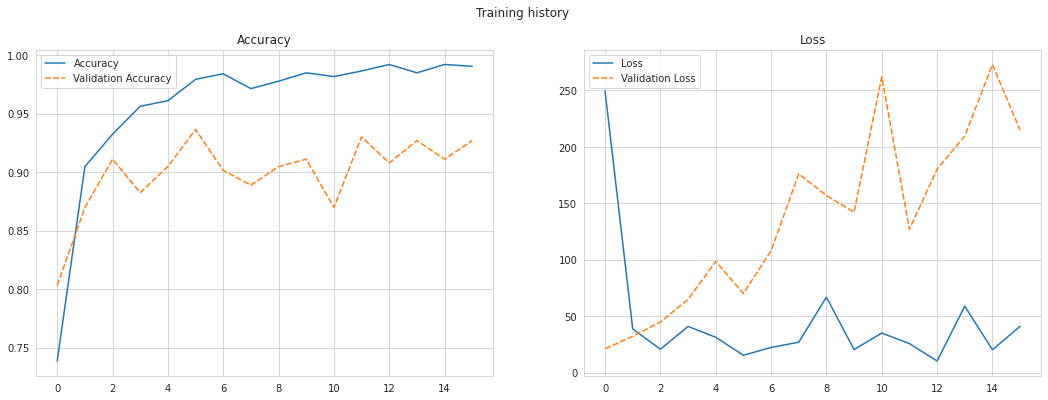

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

fig.suptitle('Training history')

sns.lineplot(ax=axes[0], data=pd.DataFrame({'Accuracy': acc, 'Validation Accuracy': val_acc})).set_title('Accuracy')
sns.lineplot(ax=axes[1], data=pd.DataFrame({'Loss': loss, 'Validation Loss': val_loss})).set_title('Loss')
sns.set_style("whitegrid")

## 7.1 Confusion Matrix

### 7.1.1 Testing the model using X_test and storing the output in y_pred

In [ ]:
# Testing the model using X_test and storing the output in y_pred
y_pred = model.predict(X_train)

### 7.1.2 All labels

In [ ]:
from sklearn.metrics import confusion_matrix

# Creating  a confusion matrix,which compares the y_test and y_pred
# https://stackoverflow.com/questions/46953967/multilabel-indicator-is-not-supported-for-confusion-matrix
cm = confusion_matrix(y_train, (y_pred > 0.6).argmax(axis=1))


# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
# cm_df = pd.DataFrame(cm, columns = ['Image', *columns])
cm_df = pd.DataFrame(cm, index=encoder.classes_, columns = encoder.classes_)

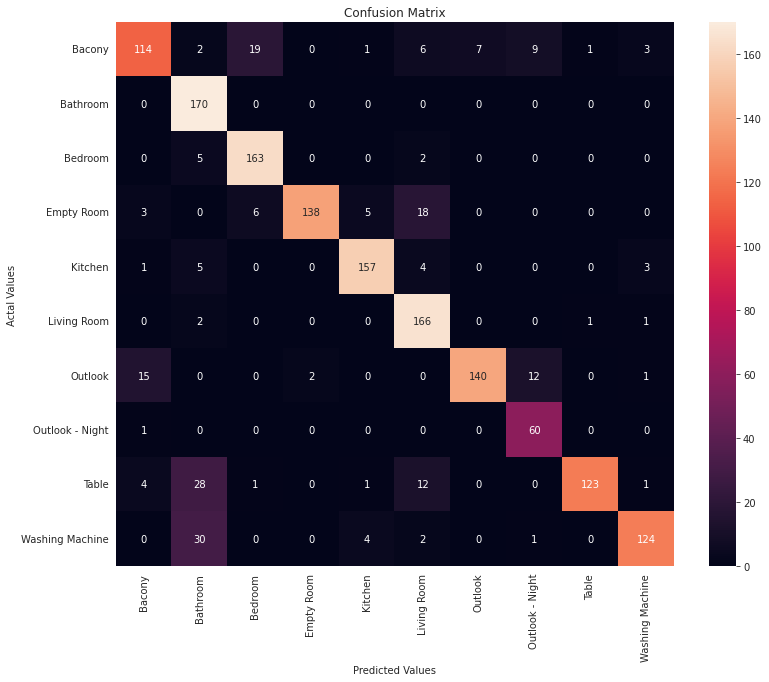

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix
plt.figure(figsize=(12.5, 10))

# https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
sns.heatmap(cm_df, annot=True, fmt='g')

plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

plt.show()
